In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import random
import os
import pickle
import string
import requests
import collections
import io
import tarfile
import urllib.request
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/yskn67/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
embedding_size = 200
vocabulary_size = 2000
batch_size = 100
max_words = 100

stops = stopwords.words('english')

In [3]:
def load_movie_data():
    save_folder_name = '../data'
    pos_file = os.path.join(save_folder_name, 'rt-polaritydata', 'rt-polarity.pos')
    neg_file = os.path.join(save_folder_name, 'rt-polaritydata', 'rt-polarity.neg')
    if not os.path.exists(os.path.join(save_folder_name, 'rt-polaritydata')):
        movie_data_url = 'http://www.cs.cornell.edu/people/pabo/movie-review-data/rt-polaritydata.tar.gz'
        req = requests.get(movie_data_url, stream=True)
        with open(os.path.join(save_folder_name, 'temp_movie_review_temp.tar.gz'), 'wb') as f:
            for chunk in req.iter_content(chunk_size=1024):
                if chunk:
                    f.write(chunk)
                    f.flush()
        tar = tarfile.open(os.path.join(save_folder_name, 'temp_movie_review_temp.tar.gz'), "r:gz")
        tar.extractall(path=save_folder_name)
        tar.close()
    
    pos_data = []
    with open(pos_file, 'r', encoding='latin-1') as f:
        for line in f:
            pos_data.append(line.encode('ascii', errors='ignore').decode())
    pos_data = [x.rstrip() for x in pos_data]
    
    neg_data = []
    with open(neg_file, 'r', encoding='latin-1') as f:
        for line in f:
            neg_data.append(line.encode('ascii', errors='ignore').decode())
    neg_data = [x.rstrip() for x in neg_data]
    
    texts = pos_data + neg_data
    target = [1] * len(pos_data) + [0] * len(neg_data)
    
    return (texts, target)

texts, target = load_movie_data()

In [4]:
def normalize_text(texts, stops):
    texts = [x.lower() for x in texts]
    texts = [''.join(c for c in x if c not in string.punctuation) for x in texts]
    texts = [''.join(c for c in x if c not in '0123456789') for x in texts]
    texts = [' '.join([word for word in x.split() if word not in (stops)]) for x in texts]
    texts = [' '.join(x.split()) for x in texts]
    return texts
texts = normalize_text(texts, stops)

In [5]:
target = [target[ix] for ix, x in enumerate(texts) if len(x.split()) > 2]
texts = [x for x in texts if len(x.split()) > 2]
train_indices = np.random.choice(len(target), round(0.8 * len(target)), replace=False)
test_indices = np.array(list(set(range(len(target))) - set(train_indices)))
texts_train = [x for ix, x in enumerate(texts) if ix in train_indices]
texts_test = [x for ix, x in enumerate(texts) if ix in test_indices]
target_train = np.array([x for ix, x in enumerate(target) if ix in train_indices])
target_test = np.array([x for ix, x in enumerate(target) if ix in test_indices])

In [6]:
dict_file = './movie_vocab.pkl'
word_dictionary = pickle.load(open(dict_file, 'rb'))

In [7]:
def text_to_numbers(sentences, word_dict):
    data = []
    for sentences in sentences:
        sentence_data = []
        for word in word_dict:
            if word in word_dict:
                word_ix = word_dict[word]
            else:
                word_ix = 0
            sentence_data.append(word_ix)
        data.append(sentence_data)
    return data
text_data_train = np.array(text_to_numbers(texts_train, word_dictionary))
text_data_test = np.array(text_to_numbers(texts_test, word_dictionary))

In [8]:
text_data_train = np.array([x[0:max_words] for x in [list(y) + [0] * max_words for y in text_data_train]])
text_data_test = np.array([x[0:max_words] for x in [list(y) + [0] * max_words for y in text_data_test]])

In [9]:
with tf.Session() as sess:
    A = tf.Variable(tf.random_normal(shape=[embedding_size, 1]))
    b = tf.Variable(tf.random_normal(shape=[1, 1]))
    x_data = tf.placeholder(shape=[None, max_words], dtype=tf.int32)
    y_target = tf.placeholder(shape=[None, 1], dtype=tf.float32)
    
    embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
    embed = tf.nn.embedding_lookup(embeddings, x_data)
    embed_avg = tf.reduce_mean(embed, 1)
    
    model_output = tf.add(tf.matmul(embed_avg, A), b)
    loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=model_output,
        labels=y_target))
    
    prediction = tf.round(tf.sigmoid(model_output))
    predictions_correct = tf.cast(tf.equal(prediction, y_target), tf.float32)
    accuracy = tf.reduce_mean(predictions_correct)
    
    my_opt = tf.train.AdagradOptimizer(0.005)
    train_step = my_opt.minimize(loss)
    init = tf.global_variables_initializer()
    sess.run(init)
    
    saver = tf.train.Saver({"embeddings": embeddings})
    saver.restore(sess, './cbow_movie_embeddings.ckpt')
    
    train_loss = []
    test_loss = []
    train_acc = []
    test_acc = []
    i_data = []
    for i in range(10000):
        rand_index = np.random.choice(text_data_train.shape[0], size=batch_size)
        rand_x = text_data_train[rand_index]
        rand_y = np.transpose([target_train[rand_index]])
        sess.run(train_step, feed_dict={x_data: rand_x, y_target: rand_y})
        
        if (i + 1) % 100 == 0:
            i_data.append(i + 1)
            train_loss_temp = sess.run(loss, feed_dict={
                x_data: rand_x,
                y_target: rand_y,
            })
            train_loss.append(train_loss_temp)
            
            test_loss_temp = sess.run(loss, feed_dict={
                x_data: text_data_test,
                y_target: np.transpose([target_test]),
            })
            test_loss.append(test_loss_temp)
            
            train_acc_temp = sess.run(accuracy, feed_dict={
                x_data: rand_x,
                y_target: rand_y,
            })
            train_acc.append(train_acc_temp)
            
            test_acc_temp = sess.run(accuracy, feed_dict={
                x_data: text_data_test,
                y_target: np.transpose([target_test]),
            })
            test_acc.append(test_acc_temp)
            
        if (i + 1) % 500 == 0:
            acc_and_loss = [i + 1, train_loss_temp, test_loss_temp, train_acc_temp, test_acc_temp]
            acc_and_loss = [np.round(x, 2) for x in acc_and_loss]
            print('Generation # {}. Train Loss (Test Loss): {:.2f} ({:.2f}).\n                  Train Acc (Test Acc): {:.2f} ({:.2f})'.format(*acc_and_loss))

INFO:tensorflow:Restoring parameters from ./cbow_movie_embeddings.ckpt
Generation # 500. Train Loss (Test Loss): 0.69 (0.69).
                  Train Acc (Test Acc): 0.58 (0.50)
Generation # 1000. Train Loss (Test Loss): 0.69 (0.69).
                  Train Acc (Test Acc): 0.55 (0.50)
Generation # 1500. Train Loss (Test Loss): 0.69 (0.69).
                  Train Acc (Test Acc): 0.55 (0.50)
Generation # 2000. Train Loss (Test Loss): 0.69 (0.69).
                  Train Acc (Test Acc): 0.52 (0.50)
Generation # 2500. Train Loss (Test Loss): 0.69 (0.69).
                  Train Acc (Test Acc): 0.51 (0.50)
Generation # 3000. Train Loss (Test Loss): 0.69 (0.69).
                  Train Acc (Test Acc): 0.60 (0.50)
Generation # 3500. Train Loss (Test Loss): 0.69 (0.69).
                  Train Acc (Test Acc): 0.49 (0.50)
Generation # 4000. Train Loss (Test Loss): 0.69 (0.69).
                  Train Acc (Test Acc): 0.46 (0.50)
Generation # 4500. Train Loss (Test Loss): 0.69 (0.69).
          

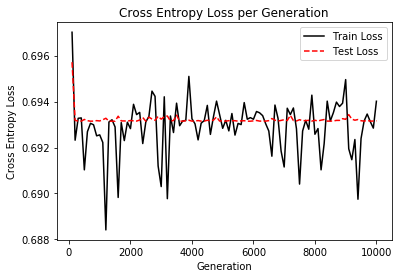

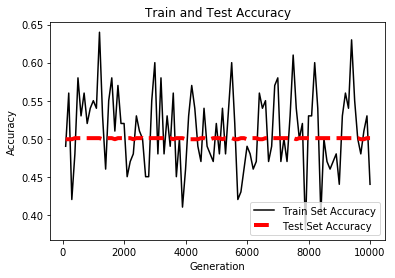

In [10]:
plt.plot(i_data, train_loss, 'k-', label='Train Loss')
plt.plot(i_data, test_loss, 'r--', label='Test Loss')
plt.title('Cross Entropy Loss per Generation')
plt.xlabel('Generation')
plt.ylabel('Cross Entropy Loss')
plt.legend(loc='upper right')
plt.show()

plt.plot(i_data, train_acc, 'k-', label='Train Set Accuracy')
plt.plot(i_data, test_acc, 'r--', label='Test Set Accuracy', linewidth=4)
plt.title('Train and Test Accuracy')
plt.xlabel('Generation')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()